In [1]:
import sympy as syms
import numpy as np
import math
import matplotlib.pyplot as plt

from sympy import symbols
from sympy import Matrix
from sympy import latex
from sympy import solve
from sympy.matrices import eye, zeros, ones, Identity # Special matrices (eye creates explicit matrix, Identity creates matrix expression)
from sympy import *


## Problem

![sys](Images/6.jpg)

To compute:
* Eigenfrequency of the structure
* Critical Time Step
* Accelerations, velocities and displacements of node 2 until $t = 0.0004 s$ with a time step of $\Delta t = 0.0001 s$ using Central Difference Method

In [38]:
k,m,F,omg = symbols('k m F omega')
# Stiffness Matrix
K = Matrix([[k,-k],[-k,k]])
# Lumped Mass Matrix
M = Matrix([[m/2,0],[0,m/2]])
# Damping Matrix
C = zeros(2)
# Force Vector
Fvec = Matrix([[0],[-F]])

# Reduced System
# Node 1 is fixed
Kred = K[1:,1:]
Mred = M[1:,1:]
Cred = C[1:,1:]
Kred

Matrix([[k]])

In [7]:
# Eigenvalue Problem of the system
evp = Kred - (omg**2)*Mred
eqn = Eq(evp.det(),0)
eqn

Eq(k - m*omega**2/2, 0)

In [9]:
# Eigenvalues
solve(eqn,omg)

[-sqrt(2)*sqrt(k/m), sqrt(2)*sqrt(k/m)]

In [11]:
# Critical Time Step
# tcrit = T/pi where T is the period which corresponds to the highest Eigenfrequency
f = solve(eqn,omg)[-1]/(2*pi)
f

sqrt(2)*sqrt(k/m)/(2*pi)

In [14]:
T = 1/f
tcrit = T/pi
tcrit.subs(k,8300e3).subs(m,0.270)

0.000180361083612646*sqrt(2)

In [13]:
8300e3

8300000.0

In [39]:
# Function for the central difference method
def CDM(M,C,K,F,delt,u0,u0_d,u0_dd,iters):
    # Description
    # iters: #Iterations
    # F: load vector at various time steps as a list
    # Integration Constants
    a0 = 1/(delt**2)
    a1 = 1/(2*delt)
    a2 = 2*a0
    a3 = 1/a2

    # Effective Mass Matrix
    Meff = a0*M + a1*C

    # Displacement at -delt (Special Starting Procedure)
    uss = ((delt**2)/2)*u0_dd - delt*u0_d + u0
    
    # Initialising the displacment vector at various time steps as a list
    u = []
    
    # At initial time
    u.append(uss) # at -delt
    u.append(u0) # at initial time
    
    for ii in range(1,iters+1):
        # ii coressponds to t
        # ii - 1 corresponds to t - delt
        # For force, ii - 1 corresponds to t
        # Effective Load Vector (at time = t)
        Feff = F[ii-1] - (K - a2*M)*u[ii] - (a0*M - a1*C)*u[ii-1]
        
        # Displacement vector (at time = t + delt)
        ut = (Meff**-1)*Feff
        
        # Appending the computed displacement vector to the list
        u.append(ut)
        
    return u

In [40]:
# Initial Conditions
# Before t = 0, the bar doesn't move
u0 = zeros(2,1)
u0_d = zeros(2,1)
u0_d[-1] = -0.7407 # Value Premeditated (Exactly how to calculate this when ICs not given)
# Accelerations at t=0
u0_dd = (M**-1)*Fvec
u0_dd

Matrix([
[     0],
[-2*F/m]])

In [60]:
# Number of required iterations
iters = 5
# Load Vector at each time step
Ft = []
for ii in range(0,iters):
    Ft.append(Fvec[1:,:]) # Constant Load Vector for the given problem
delt = 0.0001

u_cdm = CDM(Mred,Cred,Kred,Ft,delt,u0[1:,:],u0_d[1:,:],u0_dd[1:,:],iters)


for i in range(0,len(u_cdm)):
    u_cdm[i] = u_cdm[i][-1].subs(F,2000).subs(k,8300e3).subs(m,0.270)

u_cdm

[-4.07407407407247e-9,
 0,
 -0.000148144074074074,
 -0.000353355124828532,
 -0.000489466358095819,
 -0.000472794571200491,
 -0.000313589825715231]

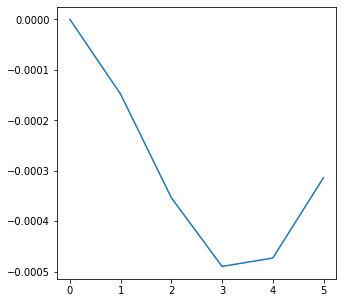

In [61]:
fig = plt.figure(figsize = (5,5))
plt.plot(u_cdm[1:])

In [62]:
# Velocities
v_cdm = []
for i in range(1,len(u_cdm)-1):
    vt = (u_cdm[i+1] - u_cdm[i-1])/(2*delt)
    v_cdm.append(vt)
v_cdm

[-0.740700000000000,
 -1.76677562414266,
 -1.70661142010872,
 -0.597197231859792,
 0.879382661902937]

In [63]:
# Accelerations
a_cdm = []
for i in range(1,len(u_cdm)-1):
    at = (u_cdm[i+1] - 2*u_cdm[i] + u_cdm[i-1])/(delt**2)
    a_cdm.append(at)
a_cdm

[-14814.8148148148,
 -5706.69766803841,
 6909.98174871717,
 15278.3020162614,
 14253.2958589931]

In [58]:
Fvec[1:,:]

Matrix([[-F]])

## Problem
![sys](Images/7.jpg)

In [147]:
m,k1,k2,p1,p2 = symbols('M k_{1} k_{2} phi_1 phi_2',real = True)
# Mass Matrix
M = Matrix([[m,0],[0,m]])
# Damping Matrix
C = zeros(2)
# Stiffness Matrix
K = Matrix([[k1+k2,-k2],[-k2,k2]])
# Simulation Time vector (Time Step = 10 ms)
# Final Time: 30 ms
delt = 0.01
t = []
F = []
t0 = 0
tf = 0.03
iters = int((tf-t0)/delt)
for j in range(0,iters):
    t.append(t0 + (j + 1)*delt)
    F.append(Matrix([[0],[-3e4*(t0 + (j + 1)*delt)]])) # Assuming Y is upward facing
# Load Vector
F 

# Eigenvectors
p1 = Matrix([[-2],[1]])
p2 = Matrix([[1],[2]])

# Modal Matrix
modal = Matrix([[p1,p2]])
modal

# Generalised Mass Matrix
Mgen = modal.T*M*modal
Mgen

# Norm for the eigenvectors
p1n = p1/sqrt(Mgen[0,0])
p2n = p2/sqrt(Mgen[-1,-1])

# Transformation Matrix
trans = Matrix([[p1n,p2n]])
trans

# transformed Mass Matrix (Should be identity)
Mtrans = trans.T*M*trans

# transformed Damping Matrix
Ctrans = trans.T*C*trans

# Transformed Stiffness Matrix
Ktrans = trans.T*K*trans
Ktrans.subs(k1,7200).subs(k2,4800).subs(m,1.5) # -> Non exponential spectral matrix

# Transformed Load Vector
Ftrans = []
for i in range(0,len(F)):
    Ftrans.append((trans.T*F[i]).subs(m,1.5))
Ftrans

[Matrix([
 [-48.9897948556636*sqrt(5)],
 [-97.9795897113271*sqrt(5)]]),
 Matrix([
 [-97.9795897113271*sqrt(5)],
 [-195.959179422654*sqrt(5)]]),
 Matrix([
 [-146.969384566991*sqrt(5)],
 [-293.938769133981*sqrt(5)]])]

In [159]:
F

[Matrix([
 [     0],
 [-300.0]]),
 Matrix([
 [     0],
 [-600.0]]),
 Matrix([
 [     0],
 [-900.0]])]

In [149]:
# Using Central Difference Method to compute generalised Displacements
x0 = zeros(2,1)
x0_d = zeros(2,1)
x0_dd = zeros(2,1) # Since load is zero at t = 0
x_cdm = CDM(Mtrans,Ctrans,Ktrans,Ftrans,delt,x0,x0_d,x0_dd,iters)

x1 = []
x2 = []

for ii in range(0,len(x_cdm)):
    x1.append(float(x_cdm[ii][0].subs(k1,7200).subs(k2,4800).subs(m,1.5)))
    x2.append(float(x_cdm[ii][-1].subs(k1,7200).subs(k2,4800).subs(m,1.5)))

In [150]:
x1

[0.0, 0.0, -0.010954451150103323, -0.0333015314963141, -0.056542495056373314]

In [151]:
x2

[0.0, 0.0, -0.021908902300206645, -0.08413018483279353, -0.19861734469275338]

In [152]:
x0

Matrix([
[0],
[0]])

In [153]:
# Physical Response
u_cdm = []
u1 = []
u2 =[]
for ii in range(0,len(x_cdm)):
    u_cdm.append(trans*x_cdm[ii])
    u1.append(u_cdm[ii][0].subs(k1,7200).subs(k2,4800).subs(m,1.5))
    u2.append(u_cdm[ii][-1].subs(k1,7200).subs(k2,4800).subs(m,1.5))

In [154]:
u1

[0, 0, 0, -0.00640000000000001, -0.0312320000000000]

In [155]:
u2

[0, 0, -0.0200000000000000, -0.0736000000000000, -0.165696000000000]

In [156]:
trans

Matrix([
[-2*sqrt(5)/(5*sqrt(M)),   sqrt(5)/(5*sqrt(M))],
[   sqrt(5)/(5*sqrt(M)), 2*sqrt(5)/(5*sqrt(M))]])